# Simple Stock Prediction

**Predicting Alphabet Inc. stock price using a Recurrent Neural Network**

Dataset from [Google Finance](https://www.google.com/finance)

Based on [RNN project: Time Series Prediction](https://github.com/udacity/aind2-rnn) project of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")
import helper_ds
import keras


helper_ds.set_parent_execution_path()
helper_ds.info_system()

# helper_ds.reproducible(seed=42)
sns.set()

Path changed to /home/angel/DRIVE/data-science-keras

HARDWARE:
CPU:	Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
RAM:	8 GB
GPU:	NVIDIA GeForce RTX 2070

OS:	Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.35

ENV:	/home/angel/miniconda3/envs/gpu

PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
tensorflow                    2.9.1
pandas                        1.4.3
numpy                        1.23.1

EXECUTION PATH: /home/angel/DRIVE/data-science-keras
EXECUTION DATE: Mon Aug 15 13:07:03 2022


## Load and process the data

In [2]:
df = pd.read_csv("data/alphabet_stock.csv")
print("Days: {}".format(len(df)))
df.head(3)

Days: 3253


,Date,Open,High,Low,Close,Volume
0,21-Jul-17,989.00,995.11,984.17,993.84,1463322
1,20-Jul-17,997.00,998.68,984.62,992.19,1418385
2,19-Jul-17,990.01,995.60,987.01,992.77,1412148


In [3]:
# Parse dates
df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%y", errors="coerce")
df.head(3)

,Date,Open,High,Low,Close,Volume
0,2017-07-21,989.00,995.11,984.17,993.84,1463322
1,2017-07-20,997.00,998.68,984.62,992.19,1418385
2,2017-07-19,990.01,995.60,987.01,992.77,1412148


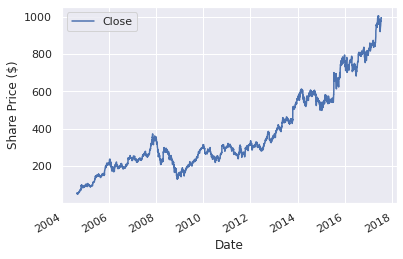

In [4]:
# Sort values by date
df = df.sort_values(by="Date")
df.plot(x="Date", y="Close")
plt.ylabel("Share Price ($)");

In [5]:
# Only Close prices will be used
data = df["Close"].values

# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
data = scaler.fit_transform(data.reshape(-1, 1))

data.reshape(-1);

### Split into sequences

Run a sliding window along the input series and creates associated input/output pairs

In [6]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []

    # fill input/output lists from the given sequence
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])  # size: sliding window
        y.append(series[i + window_size])  # size: scalar

    # reshape each
    X = np.asarray(X)
    X.shape = np.shape(X)[0:2]
    y = np.asarray(y)
    y.shape = (len(y), 1)

    return X, y


# window the data
window_size = 28  # Four weeks
X, y = window_transform_series(series=data, window_size=window_size)

### Split into training and test sets

Dataset is not randomly split as the input/output pairs are related temporally

In [7]:
# split the dataset into training / test sets

train_test_split = int(len(X) * 0.9)

X_train = X[:train_test_split, :]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:, :]
y_test = y[train_test_split:]

# Keras's LSTM module requires input reshaped to [samples, window size, stepsize]
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## Recurrent Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________

Training ...
CPU times: user 7.09 s, sys: 1.22 s, total: 8.31 s
Wall time: 8.61 s


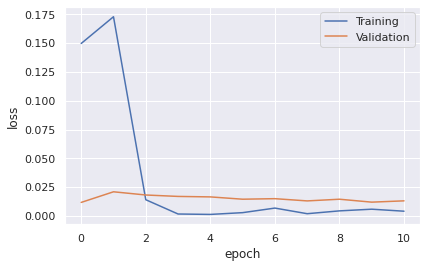


Training loss:  	0.0041
Validation loss: 	 0.0131

Model saved at models/simple_stock_prediction.h5


In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(256, input_shape=(window_size, 1)))
model.add(Dense(1, activation=None))
model.summary()

model.compile(loss='mean_squared_error', optimizer='rmsprop')

# train the model
print("\nTraining ...")
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0)]
%time  history = model.fit(X_train, y_train, epochs=100, batch_size=1024, verbose=0, \
                           validation_split=0.2, callbacks=callbacks)
helper_ds.show_training(history)

model_path = os.path.join("models", "simple_stock_prediction.h5")
model.save(model_path)
print("\nModel saved at", model_path)

### Evaluate the model

In [9]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

# print training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print("\nTraining error = {:.4f}".format(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print("Test error = {:.4f}".format(testing_error))

Model loaded: models/simple_stock_prediction.h5

Training error = 0.0074
Test error = 0.0531


In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 8ms/step


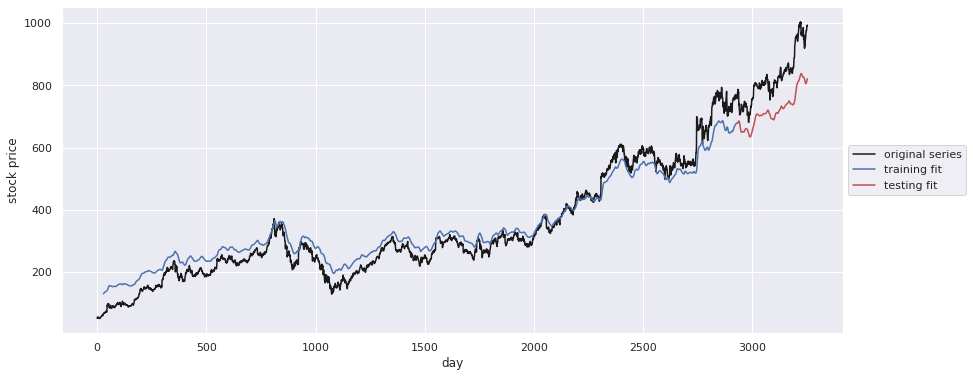

In [11]:
# revert scaling
data_or = scaler.inverse_transform(data)
train_predict_or = scaler.inverse_transform(train_predict)
test_predict_or = scaler.inverse_transform(test_predict)

plt.figure(figsize=(14, 6))

# plot original series
plt.plot(data_or, color="k")

# plot training set prediction
split_pt = train_test_split + window_size
plt.plot(np.arange(window_size, split_pt, 1), train_predict_or, color="b")

# plot testing set prediction
plt.plot(np.arange(split_pt, split_pt + len(test_predict_or), 1), test_predict_or, color="r")

plt.xlabel("day")
plt.ylabel("stock price")
plt.legend(
    ["original series", "training fit", "testing fit"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
);

The stock prices are predicted daily using the actual data from the last 4 weeks. That explains why the predictions seem so accurate.